# Binary classification using an MLP with TensorFlow

## 1. Import & Preprocessing

### a) Importing modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

### b) Importing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/Annotated Data/Churn/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Annotated Data/Churn/test.csv')

In [ ]:
train_data.head()

,CustomerId,Churned,FrequentBuyerClass,Sex,Age,NrSiblingsSpouses,NrParentsChildren
0,1,0,3,male,22.0,1,0
1,2,1,1,female,38.0,1,0
2,3,1,3,female,26.0,0,0
3,4,1,1,female,35.0,1,0
4,5,0,3,male,35.0,0,0


In [ ]:
test_data.head()

,CustomerId,FrequentBuyerClass,Sex,Age,NrSiblingsSpouses,NrParentsChildren
0,892,3,male,34.5,0,0
1,893,3,female,47.0,1,0
2,894,2,male,62.0,0,0
3,895,3,male,27.0,0,0
4,896,3,female,22.0,1,1


### c) Data preparation

In [ ]:
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix=column)], axis=1)
        data = data.drop(column, axis=1)
    return data

In [ ]:
train_data = train_data[train_data.columns[-6:]]
test_data = test_data[test_data.columns[-5:]]

In [ ]:
dummy_columns = ["FrequentBuyerClass"]
train_data=dummy_data(train_data, dummy_columns)
test_data=dummy_data(test_data, dummy_columns)

In [ ]:
train_data.head()

,Churned,Sex,Age,NrSiblingsSpouses,NrParentsChildren,FrequentBuyerClass_1,FrequentBuyerClass_2,FrequentBuyerClass_3
0,0,male,22.0,1,0,0,0,1
1,1,female,38.0,1,0,1,0,0
2,1,female,26.0,0,0,0,0,1
3,1,female,35.0,1,0,1,0,0
4,0,male,35.0,0,0,0,0,1


In [ ]:
def sex_to_int(data):
    le = LabelEncoder()
    le.fit(["male","female"])
    data["Sex"]=le.transform(data["Sex"]) 
    return data

train_data = sex_to_int(train_data)
test_data = sex_to_int(test_data)
train_data.head()

,Churned,Sex,Age,NrSiblingsSpouses,NrParentsChildren,FrequentBuyerClass_1,FrequentBuyerClass_2,FrequentBuyerClass_3
0,0,1,22.0,1,0,0,0,1
1,1,0,38.0,1,0,1,0,0
2,1,0,26.0,0,0,0,0,1
3,1,0,35.0,1,0,1,0,0
4,0,1,35.0,0,0,0,0,1


In [ ]:
def normalize_age(data):
    scaler = MinMaxScaler()
    data["Age"] = scaler.fit_transform(data["Age"].values.reshape(-1,1))
    return data
train_data = normalize_age(train_data)
test_data = normalize_age(test_data)
train_data.head()

,Churned,Sex,Age,NrSiblingsSpouses,NrParentsChildren,FrequentBuyerClass_1,FrequentBuyerClass_2,FrequentBuyerClass_3
0,0,1,0.271174,1,0,0,0,1
1,1,0,0.472229,1,0,1,0,0
2,1,0,0.321438,0,0,0,0,1
3,1,0,0.434531,1,0,1,0,0
4,0,1,0.434531,0,0,0,0,1


In [ ]:
train_data.Age.fillna(train_data.Age.median(),inplace=True)
test_data.Age.fillna(test_data.Age.median(),inplace=True)

In [ ]:
def split_valid_test_data(data, fraction=(0.2)):
    y_data = data["Churned"]

    x_data = data.drop(["Churned"], axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=fraction)

    return x_train.values, y_train, x_test, y_test

x_train, y_train, x_test, y_test = split_valid_test_data(train_data)
print("x_train:{}, {}".format(x_train.shape, type(x_train)))
print("y_train:{}, {}".format(y_train.shape, type(y_train)))

print("x_test:{}, {}".format(x_test.shape, type(x_test)))
print("y_test:{}, {}".format(y_test.shape, type(y_test)))

x_train:(712, 7), <class 'numpy.ndarray'>
y_train:(712,), <class 'pandas.core.series.Series'>
x_test:(179, 7), <class 'pandas.core.frame.DataFrame'>
y_test:(179,), <class 'pandas.core.series.Series'>


In [ ]:
y_train = y_train.values
x_test = x_test.values
y_test = y_test.values

## 2. Model specific data preparation

### a) Load the data

In [ ]:
x_train_tf = tf.convert_to_tensor(x_train)
y_train_tf = tf.convert_to_tensor(y_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_test_tf = tf.convert_to_tensor(y_test)

### b) Tensor view of the data

In [ ]:
x_train_tf[0]

In [ ]:
y_train_tf[0]

<tf.Tensor: shape=(), dtype=int64, numpy=0>

## 3. Model definition

### a) Sequentially add layers

In [ ]:
initializer = tf.random_uniform_initializer(
    minval=-1, maxval=1, seed=123)

In [ ]:
model_tf = keras.models.Sequential([
     keras.layers.Dense(16, input_dim=x_train_tf.shape[1], activation='relu', kernel_initializer=initializer),
     keras.layers.Dense(32, activation='relu', kernel_initializer=initializer),
     keras.layers.Dense(1,activation='sigmoid', kernel_initializer=initializer)])

### b) Inspect the model

In [ ]:
model_tf.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16)                128       
_________________________________________________________________
dense_25 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 33        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


### c) Inspect the first hidden layer

In [ ]:
hidden1_tf_ante = model_tf.layers[0]
weights_tf_ante, biases_tf_ante = hidden1_tf_ante.get_weights()
weights_tf_ante[0]

array([[-0.04798412, -0.22223973, -0.9824271 , -0.57410717, -0.79084826,
        -0.6723347 , -0.54534245, -0.14903617,  0.22151732, -0.04990911,
         0.76847243,  0.8567488 , -0.19580126,  0.6683371 , -0.29299927,
        -0.13567281],
       [ 0.43682718, -0.5372863 , -0.8050833 ,  0.33245063,  0.08226037,
         0.9955554 ,  0.42286134,  0.5824466 , -0.88201547,  0.79022574,
        -0.96988153,  0.8838699 ,  0.7405057 , -0.26739526,  0.541693  ,
        -0.33356333],
       [-0.5114386 ,  0.28969407, -0.5687852 , -0.9064033 ,  0.55588317,
         0.12526917,  0.76767826,  0.9882431 ,  0.82163215, -0.83939624,
        -0.1760552 , -0.8733709 ,  0.54416513,  0.3740089 ,  0.67598724,
         0.7747915 ],
       [-0.22487664, -0.7704594 ,  0.11647105,  0.735404  , -0.8178191 ,
         0.80086374, -0.596689  ,  0.43223333,  0.6735773 ,  0.28332973,
        -0.15904045,  0.38079   , -0.8442614 ,  0.4907596 , -0.25315404,
         0.02004218],
       [-0.3033669 , -0.2716992 , -0

In [ ]:
weights_tf_ante.shape

(7, 16)

In [ ]:
biases_tf_ante

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
biases_tf_ante.shape

(16,)

## 4. Loss & Optimizer

In [ ]:
optimizer_tf = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
loss_fn_tf = keras.losses.BinaryCrossentropy()

test_loss = tf.keras.metrics.Mean(name='test_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

## 5. Training

### a) Training loop

In [ ]:
def train_step_tf(model, optimizer, loss_fn, batch_size = 10):
  losses = []
  for beg_i in range(0, x_train_tf.shape[0], batch_size):
    x_train_batch_tf = x_train_tf[beg_i:beg_i + batch_size]
    y_train_batch_tf = y_train_tf[beg_i:beg_i + batch_size]

    with tf.GradientTape() as tape:
      y_pred_tf = model(x_train_batch_tf, training=True)
      loss = loss_fn(y_train_batch_tf, y_pred_tf)

    grads = tape.gradient(loss, model.trainable_weights)

    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    losses.append(loss)
    train_accuracy.update_state(y_train_batch_tf, y_pred_tf)
  return losses

In [ ]:
def test_step_tf(model, optimizer, loss_fn, batch_size = 10):
  for beg_i in range(0, x_train_tf.shape[0], batch_size):
    x_test_batch_tf = x_train_tf[beg_i:beg_i + batch_size]
    y_test_batch_tf = y_train_tf[beg_i:beg_i + batch_size]
    y_pred_tf = model(x_test_batch_tf, training=False)
    loss = loss_fn(y_test_batch_tf, y_pred_tf)
    test_loss.update_state(loss)
    test_accuracy.update_state(y_test_batch_tf, y_pred_tf)


In [ ]:
train_loss_tf = []
test_loss_tf = []

train_acc_tf = []
test_acc_tf = []

epochs = 200
for epoch in range(epochs):
  loss = train_step_tf(model_tf, optimizer_tf, loss_fn_tf)
  mean_loss_tf = float(tf.reduce_mean(loss))

  test_step_tf(model_tf, optimizer_tf, loss_fn_tf)

  template = ("Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}")
  print(template.format(epoch+1, mean_loss_tf, train_accuracy.result()*100, test_loss.result(), test_accuracy.result()*100))

  train_loss_tf.append(mean_loss_tf)
  test_loss_tf.append(test_loss.result())

  train_acc_tf.append(train_accuracy.result()*100)
  test_acc_tf.append(test_accuracy.result()*100)
  test_loss.reset_states()
  train_accuracy.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: 1.3777427673339844, Accuracy: 50.00000762939453, Test Loss: 0.9002404808998108, Test Accuracy: 67.77777099609375
Epoch 2, Loss: 0.7315196394920349, Accuracy: 60.62499237060547, Test Loss: 0.7565468549728394, Test Accuracy: 70.55554962158203
Epoch 3, Loss: 0.5681494474411011, Accuracy: 65.0462875366211, Test Loss: 0.6798701286315918, Test Accuracy: 72.54627990722656
Epoch 4, Loss: 0.5125542283058167, Accuracy: 68.19441986083984, Test Loss: 0.6332415342330933, Test Accuracy: 73.95829772949219
Epoch 5, Loss: 0.48958805203437805, Accuracy: 70.33329010009766, Test Loss: 0.6020035743713379, Test Accuracy: 75.16659545898438
Epoch 6, Loss: 0.4770357310771942, Accuracy: 71.80552673339844, Test Loss: 0.579500138759613, Test Accuracy: 76.04158782958984
Epoch 7, Loss: 0.46889474987983704, Accuracy: 73.0158462524414, Test Loss: 0.5623997449874878, Test Accuracy: 76.66658782958984
Epoch 8, Loss: 0.4623766541481018, Accuracy: 73.92357635498047, Test Loss: 0.5488364696502686, Test Accur

### b) Training progress

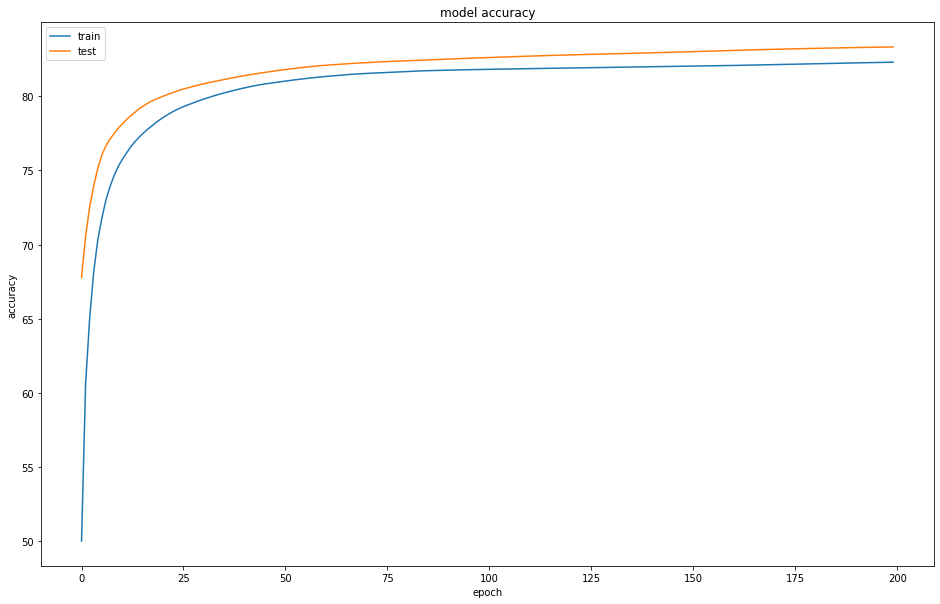

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train_acc_tf)
plt.plot(test_acc_tf)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

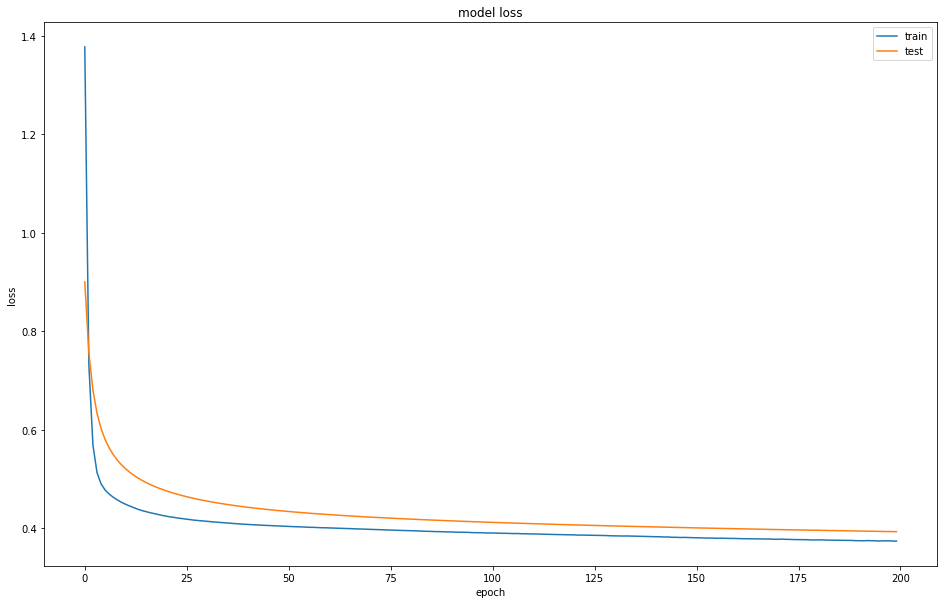

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train_loss_tf)
plt.plot(test_loss_tf)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.show()

### c) Inspect the first hidden layer after training

In [ ]:
hidden1_tf_post = model_tf.layers[0]
weights_tf_post, biases_tf_post = hidden1_tf_post.get_weights()
weights_tf_post[0]

array([ 0.00132329, -0.73867315, -0.9824271 , -0.8490269 , -0.94622636,
       -0.83066154, -0.43457136, -0.02996767,  0.08205871,  0.07087262,
        1.016763  ,  0.6506471 , -0.4369644 ,  0.8620826 , -0.39503822,
       -0.3304177 ], dtype=float32)

In [ ]:
biases_tf_post

array([-5.3562007 , -0.4668604 , -0.55462223, -4.2935047 , -0.58293504,
       -2.7463944 , -0.5805321 , -0.4475423 , -0.59723175, -0.5623835 ,
       -5.0688033 , -1.1123146 , -3.1899436 , -0.5984557 , -2.088271  ,
       -0.29426077], dtype=float32)

## 6. Evaluation

In [ ]:
y_pred_tf = (model_tf.predict(x_test) > 0.5).astype('int32')

In [ ]:
accuracy_score(y_test,y_pred_tf)

0.8379888268156425